# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering
4. Build Predictive Model

---

## 1. Import packages

In [134]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from dateutil.relativedelta import relativedelta
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

---
## 2. Load data

In [141]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [111]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.
1. “Churn” contains the value 0 for customer who doesn't churn, and 1 for patients who churns
2. Random Forest doesn't require feature scaling

In [142]:
price_df = pd.read_csv('price_data (1).csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [113]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [114]:
df = pd.merge(df, diff, on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916


## Average price changes across periods ##
add more granularity to the existing feature. 

Instead of looking at differences across an entire year, we have now created features that look at mean average price differences across different time periods (`off_peak`, `peak`, `mid_peak`). The dec-jan feature may reveal macro patterns that occur over an entire year, whereas inter-time-period features may reveal patterns on a micro scale between months

In [115]:
# Aggregate average prices per period by company
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [116]:
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [117]:
columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


## Max price changes across periods ##
Another way we can enhance the feature is to look at the maximum change in prices across periods and months.

Calculating the maximum price change between months and time periods would be a good feature to create. As a Utilities customer, there is nothing more annoying than sudden price changes between months, and a large increase in prices within a short time span would be an influencing factor in causing customers to look at other utilities providers for a better deal. 

In [118]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [120]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [123]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [ ]:
columns = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

## Tenue ##
how long a company has been a client of PowerCo

In [143]:
def calculate_tenure(row):
    return relativedelta(row['date_end'], row['date_activ']).years

df['tenure'] = df.apply(calculate_tenure, axis=1)

In [144]:
df[['date_activ', 'date_end', 'tenure']]

,date_activ,date_end,tenure
0,2013-06-15,2016-06-15,3
1,2009-08-21,2016-08-30,7
2,2010-04-16,2016-04-16,6
3,2010-03-30,2016-03-30,6
4,2010-01-13,2016-03-07,6
...,...,...,...
14601,2012-05-24,2016-05-08,3
14602,2012-08-27,2016-08-27,4
14603,2012-02-08,2016-02-07,3
14604,2012-08-30,2016-08-30,4


This is an interesting feature to keep for modelling because clearly how long you've been a client, has a influence on the chance of a client churning.
- Companies who have only been a client for 4 or less years are much more likely to churn compared to companies that have been a client for longer.
- The difference between 4 and 5 years is about 4%, which represents a large jump in likelihood for a customer to churn compared to the other differences between ordered tenure values. Perhaps this reveals that getting a customer to over 4 years tenure is actually a large milestone with respect to keeping them as a long term customer.

In [145]:
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn', ascending=False)

,churn
tenure,
2,0.171875
3,0.140351
4,0.127636
13,0.095238
5,0.088992
12,0.083333
6,0.078161
7,0.073485
11,0.060109


## Transforming dates into months ##
Dates as a datetime object are not useful for a predictive model, so we needed to use the datetimes to create some other features that may hold some predictive power.

1. `months_activ`: assume that a client who has been an active client of PowerCo for a longer amount of time may have more loyalty to the brand and is more likely to stay. Whereas a newer client may be more volatile.

2. `months_to_end`: assume you're coming toward the end of your contract with PowerCo, you could be looking for better deals for when your contract ends, or you might want to see out your contract and sign another one; One the other hand if you've only just joined, you may have a period where you're allowed to leave if you're not satisfied. Furthermore, if you're in the middle of your contract, their may be charges if you wanted to leave, deterring clients from churning mid-way through their agreement. 

3.  `months_modif_prod`: if a client has made recent updates to their contract, they are more likely to be satisfied or at least they have received a level of customer service to update or change their existing services. I believe this to be a positive sign as they are an engaged customer.

4. `months_renewal`: the number of months since a client last renewed a contract, it shows the degree to which that client is engaged. It also goes a step further than just engagement, it shows a level of commitment if a client renews their contract. 

In [146]:
def convert_months(reference_date, target_date):
    delta = relativedelta(target_date, reference_date)
    return delta.years * 12 + delta.months

In [148]:
# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df['months_activ'] = df['date_activ'].apply(lambda x: convert_months(reference_date, x))
df['months_to_end'] = df['date_end'].apply(lambda x: -convert_months(reference_date, x))
df['months_modif_prod'] = df['date_modif_prod'].apply(lambda x: convert_months(reference_date, x))
df['months_renewal'] = df['date_renewal'].apply(lambda x: convert_months(reference_date, x))

In [149]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,...,44.235794,2.086425,9.953056e+01,4.423670e+01,1,3,-30,-5,-2,-6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,...,0.000000,0.009485,1.217891e-03,0.000000e+00,0,7,-76,-7,-76,-4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,...,0.000000,0.000004,9.450150e-08,0.000000e+00,0,6,-68,-3,-68,-8
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,...,0.000000,0.000003,0.000000e+00,0.000000e+00,0,6,-69,-2,-69,-9
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,...,0.000000,0.000011,2.896760e-06,4.860000e-10,0,6,-71,-2,-71,-9


## handle & transform categorial data ##

'has gas' column looks good, only 2 values

In [150]:
df['has_gas'].value_counts()

has_gas
f    11955
t     2651
Name: count, dtype: int64

In [151]:
df['has_gas']=df['has_gas'].replace(['t','f'],[1,0])

If a customer also buys gas from PowerCo, it shows that they have multiple products and are a loyal customer to the brand. Hence, it is no surprise that customers who do not buy gas are almost 2% more likely to churn than customers who also buy gas from PowerCo. Hence, this is a useful feature.

In [153]:
df.groupby(['has_gas']).agg({'churn': 'mean'})

,churn
has_gas,
0,0.100544
1,0.081856


There is imbalance in the number of values for channel_sales and origin_up so we will remove the values with very little occurences comparing with others.

In [152]:
df['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

In [54]:
df['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

A predictive model cannot accept categorical or `string` values, hence need to encode categorical features into numerical

In [55]:
#One hot encoding using get_dummies()
df = pd.get_dummies(df, columns = ['channel_sales', 'origin_up'])

for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

In [56]:
#remove values with very little occurences
df = df.drop(columns=['channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_sales_epumfxlbckeskwekxbiuasklxalciiuu','channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa',
                     'origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,channel_sales_MISSING,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,...,0.020057,3.700961,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,...,-0.003767,0.177779,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,...,-0.004670,0.177779,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,...,-0.004547,0.177779,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,...,-0.006192,0.162916,1,0,0,0,0,1,0,0


## handle & transform numeric data ##

mainly to handle the skewed data found in the EDA process. The std for most of the features are quite high, too skewed. There's no missing values found in EDA, so no need to handle it.

In [158]:
numeric_feature=df[['cons_12m','cons_gas_12m','cons_last_month',
                    'forecast_cons_12m','forecast_cons_year','forecast_discount_energy','forecast_meter_rent_12m',
                    'forecast_price_energy_off_peak','forecast_price_energy_peak','forecast_price_pow_off_peak']]

numeric_feature.describe().T

,count,mean,std,min,25%,50%,75%,max
cons_12m,14606.0,9.725978,2.036672,0.0,8.643958,9.555100,10.615573,15.641205
cons_gas_12m,14606.0,1.794277,3.953703,0.0,0.000000,0.000000,0.000000,15.239725
cons_last_month,14606.0,5.214541,4.073975,0.0,0.000000,6.676453,8.126814,13.555708
forecast_cons_12m,14606.0,6.820665,1.574028,0.0,6.206566,7.015600,7.784386,11.325437
forecast_cons_year,14606.0,4.109217,3.649566,0.0,0.000000,5.752573,7.465512,12.074688
forecast_discount_energy,14606.0,0.117242,0.615683,0.0,0.000000,0.000000,0.000000,3.433987
forecast_meter_rent_12m,14606.0,3.493489,1.315884,0.0,2.843746,2.985429,4.883029,6.397446
forecast_price_energy_off_peak,14606.0,0.128407,0.021732,0.0,0.110055,0.133802,0.136581,0.242133
forecast_price_energy_peak,14606.0,0.048166,0.046734,0.0,0.000000,0.080785,0.094252,0.178962
forecast_price_pow_off_peak,14606.0,3.767162,0.309093,0.0,3.728261,3.813558,3.813558,4.098774


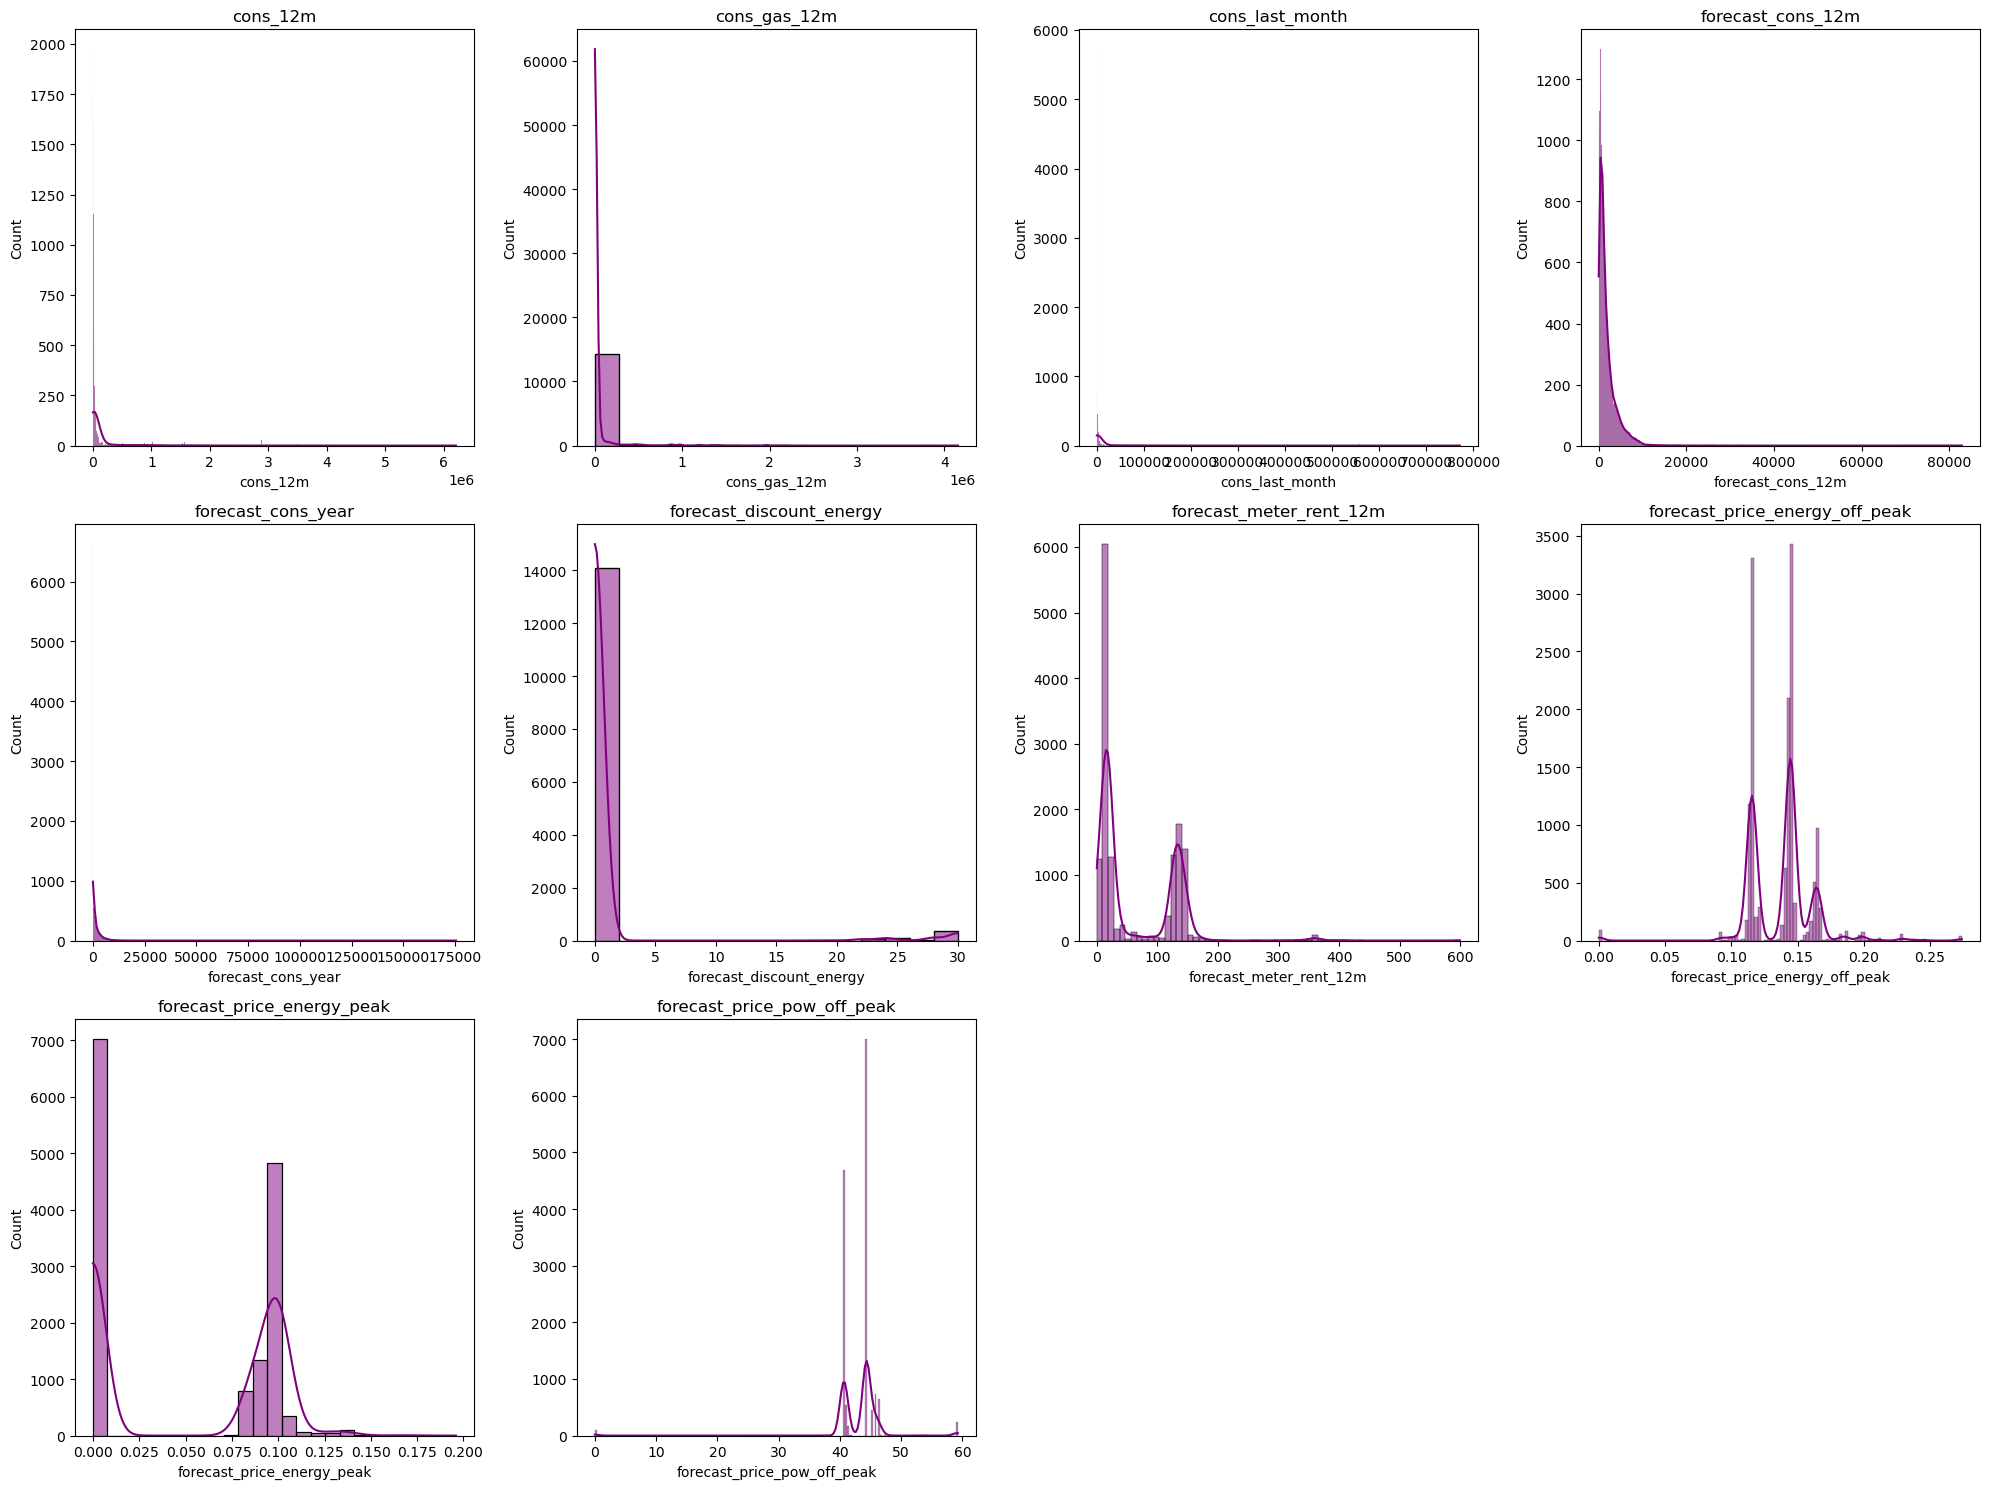

In [58]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
axs = axs.flatten()

for i, col in enumerate(numeric_feature):
    sns.histplot(df[col], kde=True, ax=axs[i], color="purple")
    axs[i].set_title(col)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

Apply log10 transformation. but we cannot apply log to a value of 0, so we will add a constant of 1 to all the values

In [159]:
for i in numeric_feature:
    df[i]=df[i].apply(lambda x:np.log10(1+x))

In [160]:
numeric_feature.describe().T

,count,mean,std,min,25%,50%,75%,max
cons_12m,14606.0,9.725978,2.036672,0.0,8.643958,9.555100,10.615573,15.641205
cons_gas_12m,14606.0,1.794277,3.953703,0.0,0.000000,0.000000,0.000000,15.239725
cons_last_month,14606.0,5.214541,4.073975,0.0,0.000000,6.676453,8.126814,13.555708
forecast_cons_12m,14606.0,6.820665,1.574028,0.0,6.206566,7.015600,7.784386,11.325437
forecast_cons_year,14606.0,4.109217,3.649566,0.0,0.000000,5.752573,7.465512,12.074688
forecast_discount_energy,14606.0,0.117242,0.615683,0.0,0.000000,0.000000,0.000000,3.433987
forecast_meter_rent_12m,14606.0,3.493489,1.315884,0.0,2.843746,2.985429,4.883029,6.397446
forecast_price_energy_off_peak,14606.0,0.128407,0.021732,0.0,0.110055,0.133802,0.136581,0.242133
forecast_price_energy_peak,14606.0,0.048166,0.046734,0.0,0.000000,0.080785,0.094252,0.178962
forecast_price_pow_off_peak,14606.0,3.767162,0.309093,0.0,3.728261,3.813558,3.813558,4.098774


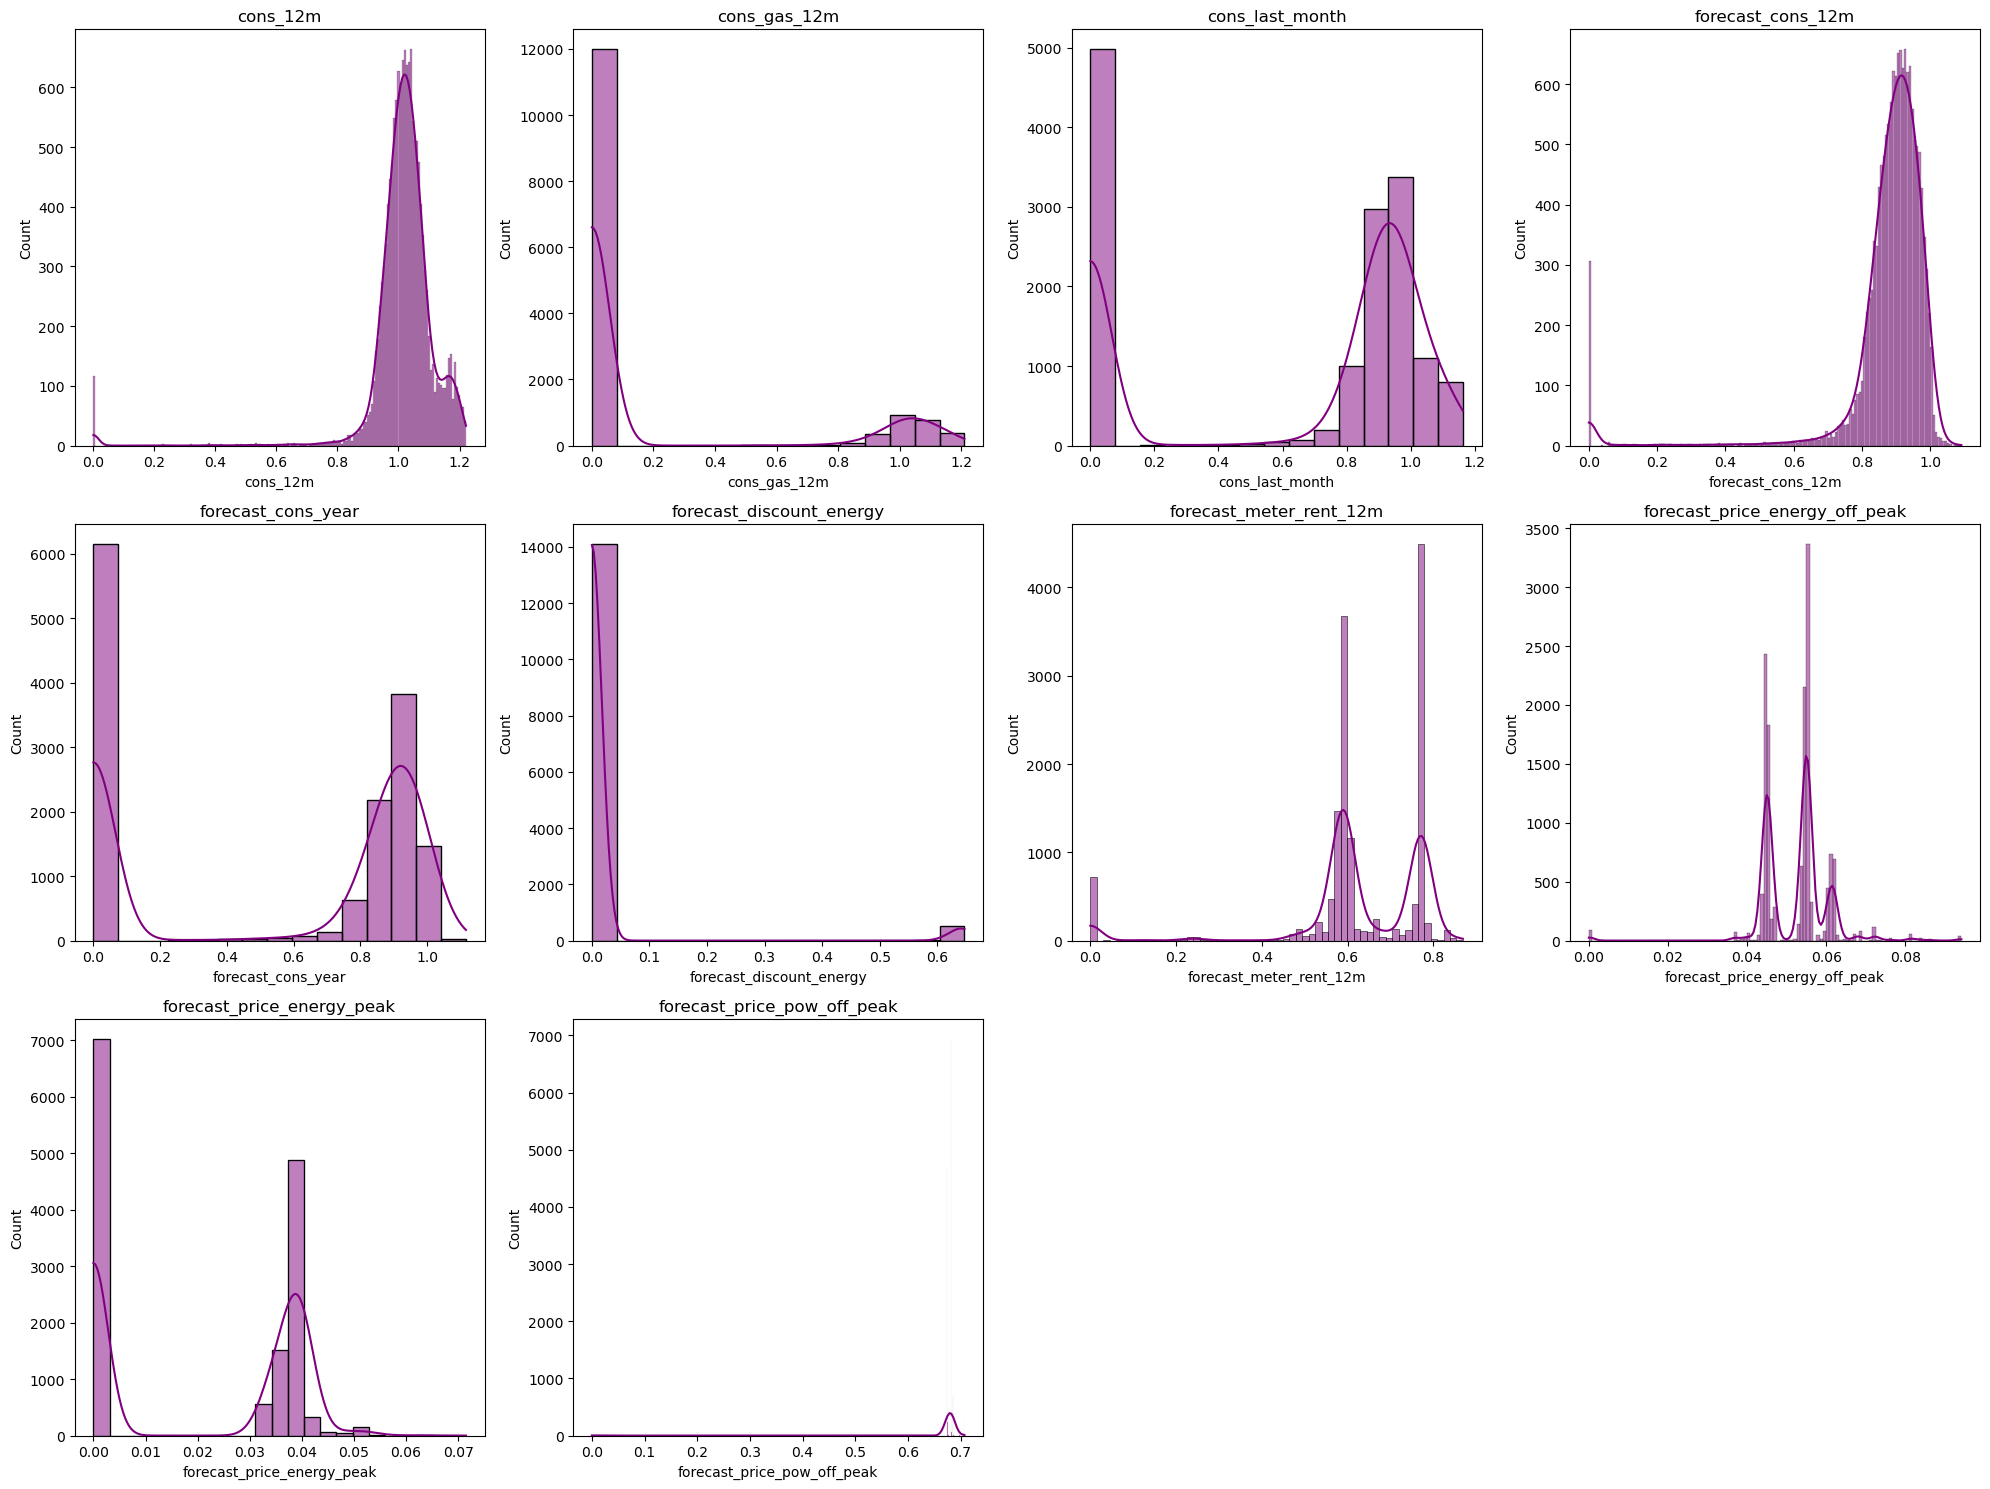

In [161]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
axs = axs.flatten()

for i, col in enumerate(numeric_feature):
    sns.histplot(df[col], kde=True, ax=axs[i], color="purple")
    axs[i].set_title(col)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Correlations ##

remove the features that are not independent from each others; also remove features that has low correlations with churn.

Ideally, you want a set of features that have 0 correlation with all of the independent variables (all features except our target variable) and a high correlation with the target variable (churn).

In [60]:
numeric_cols = df.select_dtypes(include='number').columns
corr = df[numeric_cols].corr()

In [63]:
numeric_cols

Index(['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max',
       'var_year_price_off_peak_var', 'var_year_price_peak_var',
       'var_year_price_mid_peak_var', 'var_year_price_off_peak_fix',
       'var_year_price_peak_fix', 'var_year_price_mid_peak_fix',
       'var_year_price_off_peak', 'var_year_price_peak',
       'var_year_price_mid_peak', 'var_6m_price_off_peak_var',
       'var_6m_price_peak_var', 'var_6m_price_mid_peak_var',
       'var_6m_price_off_peak_fix', 'var_6m_price_peak_fix',
       'var_6m_price_mid_peak_fix', 'var_6m_price_off_peak',
       'var_6m_price_peak', 'var_6m_price_mid_peak', 'churn',
       'offpeak_diff_dec_j

In [61]:
corr

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,channel_sales_MISSING,channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci,channel_sales_foosdfpfkusacimwkcsosbicdxkicaua,channel_sales_lmkebamcaaclubfxadlmueccxoimlema,channel_sales_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
cons_12m,1.000000,0.209637,0.623493,0.557186,0.321928,-0.027536,0.201488,-0.143048,0.278308,-0.051862,...,-0.059687,-0.079647,-0.084505,-0.064549,-0.021040,0.300029,-0.125876,0.032191,-0.026175,-0.006561
cons_gas_12m,0.209637,1.000000,0.171077,0.108450,0.084575,0.002409,0.063462,-0.040762,0.075662,0.006417,...,-0.010176,-0.016742,0.030565,-0.008177,-0.046458,0.048664,-0.014001,0.000443,0.001582,-0.002899
cons_last_month,0.623493,0.171077,1.000000,0.292725,0.786051,-0.013864,0.326362,-0.235679,0.396797,-0.042499,...,-0.072878,-0.045556,-0.058077,-0.066062,0.010777,0.205685,-0.111115,-0.031805,-0.023550,0.049516
forecast_cons_12m,0.557186,0.108450,0.292725,1.000000,0.361325,0.057713,0.222187,0.058293,0.220166,0.280672,...,-0.053204,-0.082634,-0.099932,-0.006704,0.055963,0.081416,-0.034369,-0.031513,-0.020166,0.046185
forecast_cons_year,0.321928,0.084575,0.786051,0.361325,1.000000,0.015979,0.391082,-0.295384,0.431254,-0.054850,...,-0.080907,-0.049714,-0.035257,-0.034238,0.057864,0.038128,-0.062021,-0.097037,-0.012083,0.099111
forecast_discount_energy,-0.027536,0.002409,-0.013864,0.057713,0.015979,1.000000,-0.004132,0.341919,0.057972,0.026639,...,0.441991,0.076250,-0.039652,-0.009355,0.056117,-0.053219,0.032279,-0.061712,-0.030648,0.080225
forecast_meter_rent_12m,0.201488,0.063462,0.326362,0.222187,0.391082,-0.004132,1.000000,-0.423002,0.651167,0.110899,...,-0.154363,-0.057251,-0.008968,-0.006481,0.035963,0.018300,-0.062369,-0.058502,0.053057,0.010821
forecast_price_energy_off_peak,-0.143048,-0.040762,-0.235679,0.058293,-0.295384,0.341919,-0.423002,1.000000,-0.330108,0.558077,...,0.413607,0.200290,-0.078563,0.018950,-0.004248,0.011807,0.095862,0.121756,-0.081894,-0.044282
forecast_price_energy_peak,0.278308,0.075662,0.396797,0.220166,0.431254,0.057972,0.651167,-0.330108,1.000000,-0.021651,...,-0.097314,-0.065486,0.019082,-0.017604,-0.021287,0.093223,-0.083456,-0.007044,0.054319,-0.039169
forecast_price_pow_off_peak,-0.051862,0.006417,-0.042499,0.280672,-0.054850,0.026639,0.110899,0.558077,-0.021651,1.000000,...,-0.010941,0.053363,-0.094474,0.012052,0.058346,-0.005376,0.037448,0.057426,-0.031000,-0.027901


remove some variables that exhibit a high correlation with other independent features

In [163]:
remove = ['num_years_antig', 'forecast_cons_year']

df = df.drop(columns=remove)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0.000000,1.076062,0.000000,0.000000,0.0,0.305878,0.044692,0.038866,...,44.235794,2.086425,9.953056e+01,4.423670e+01,1,3,-30,-5,-2,-6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,0.975293,0.000000,0.000000,0.796020,0.0,0.585345,0.055388,0.000000,...,0.000000,0.009485,1.217891e-03,0.000000e+00,0,7,-76,-7,-76,-4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,0.863370,0.000000,0.000000,0.689398,0.0,0.670418,0.061981,0.035129,...,0.000000,0.000004,9.450150e-08,0.000000e+00,0,6,-68,-3,-68,-8
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,0.922639,0.000000,0.000000,0.811907,0.0,0.605994,0.055716,0.000000,...,0.000000,0.000003,0.000000e+00,0.000000e+00,0,6,-69,-2,-69,-9
4,149d57cf92fc41cf94415803a877cb4b,MISSING,0.972908,0.000000,0.861367,0.851381,0.0,0.769991,0.045541,0.039543,...,0.000000,0.000011,2.896760e-06,4.860000e-10,0,6,-71,-2,-71,-9


---

## 4. Building Prediction Model

In [74]:
# Separate target variable from independent variables
X = df.drop(columns=['id', 'churn'])
y = df['churn']

In [75]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

The number of churn and not churn is imbalanced. Will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique to solve the this problem

In [76]:
y.value_counts()

churn
0    13187
1     1419
Name: count, dtype: int64

In [77]:
y_train.value_counts()

churn
0    9197
1    1027
Name: count, dtype: int64

In [78]:
from imblearn.over_sampling import SMOTE
X, y = SMOTE().fit_resample(X, y)

In [79]:
y.value_counts()

churn
1    13187
0    13187
Name: count, dtype: int64

## logistic regression ##

In [81]:
from sklearn.linear_model import LogisticRegression

#正则化强度较小，从而限制对特征权重的惩罚较弱，允许模型有更高的复杂度；
#solver 参数指定了优化算法。liblinear 是一个适用于小数据集的优化器，通常用于线性模型，如逻辑回归
reg = 0.01
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)
print (model)

LogisticRegression(C=100.0, solver='liblinear')


In [82]:
y_pred = model.predict(X_test)

In [87]:
from sklearn.metrics import accuracy_score
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.9100867183934277


1. With the true positives, we can see that in total we have 392 clients that churned in the test dataset. However, we are only able to correctly identify 3 of those 392, which is very poor.
2. Looking at the accuracy score, this is very misleading! Hence the use of precision and recall is important. The accuracy score is high, but it does not tell us the whole story.
3. Looking at the precision score and recall score, this shows us a score of 0.375 and 0.007 which are very bad. This is not a good model.

In [85]:
from sklearn import metrics
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

True positives: 3
False positives: 5
True negatives: 3985
False negatives: 389



In [86]:
from sklearn.metrics import precision_score, recall_score

print("Overall Precision:",precision_score(y_test, y_pred))
print("Overall Recall:",recall_score(y_test, y_pred))

Overall Precision: 0.375
Overall Recall: 0.007653061224489796


## random forest ##

In [90]:
from sklearn.ensemble import RandomForestClassifier

model_RF = RandomForestClassifier(n_estimators = 1000).fit(X_train, y_train)
print (model_RF)

RandomForestClassifier(n_estimators=1000)


1. With the true positives, we correctly identify 22 of those 393, which is very poor.
2. The accuracy score is very misleading; the precision score is 0.86 which is not bad, but the recall of 0.05 shows us that the classifier has a very poor ability to identify positive samples. This would be the main concern for improving this model: **we’re able to accurately identify clients that do not churn, but not so accurately identify clients that will churn.**

In [92]:
y_pred_RF = model_RF.predict(X_test)

tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred_RF).ravel()
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")


print('Accuracy:', accuracy_score(y_test, y_pred_RF))
print("Overall Precision:",precision_score(y_test, y_pred_RF))
print("Overall Recall:",recall_score(y_test, y_pred_RF))

True positives: 19
False positives: 3
True negatives: 3987
False negatives: 373

Accuracy: 0.9141944317663168
Overall Precision: 0.8636363636363636
Overall Recall: 0.04846938775510204


## Model Understanding ##

Feature importances indicate the importance of a feature within the predictive model.
- Consumption over 12 months and forecast meter rent 12 month are a top driver for churn in this model
- Net margin also plays an important role in the predictive model.
- Our price sensitivity features are scattered around but are not the main driver for a customer churning

In [93]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model_RF.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

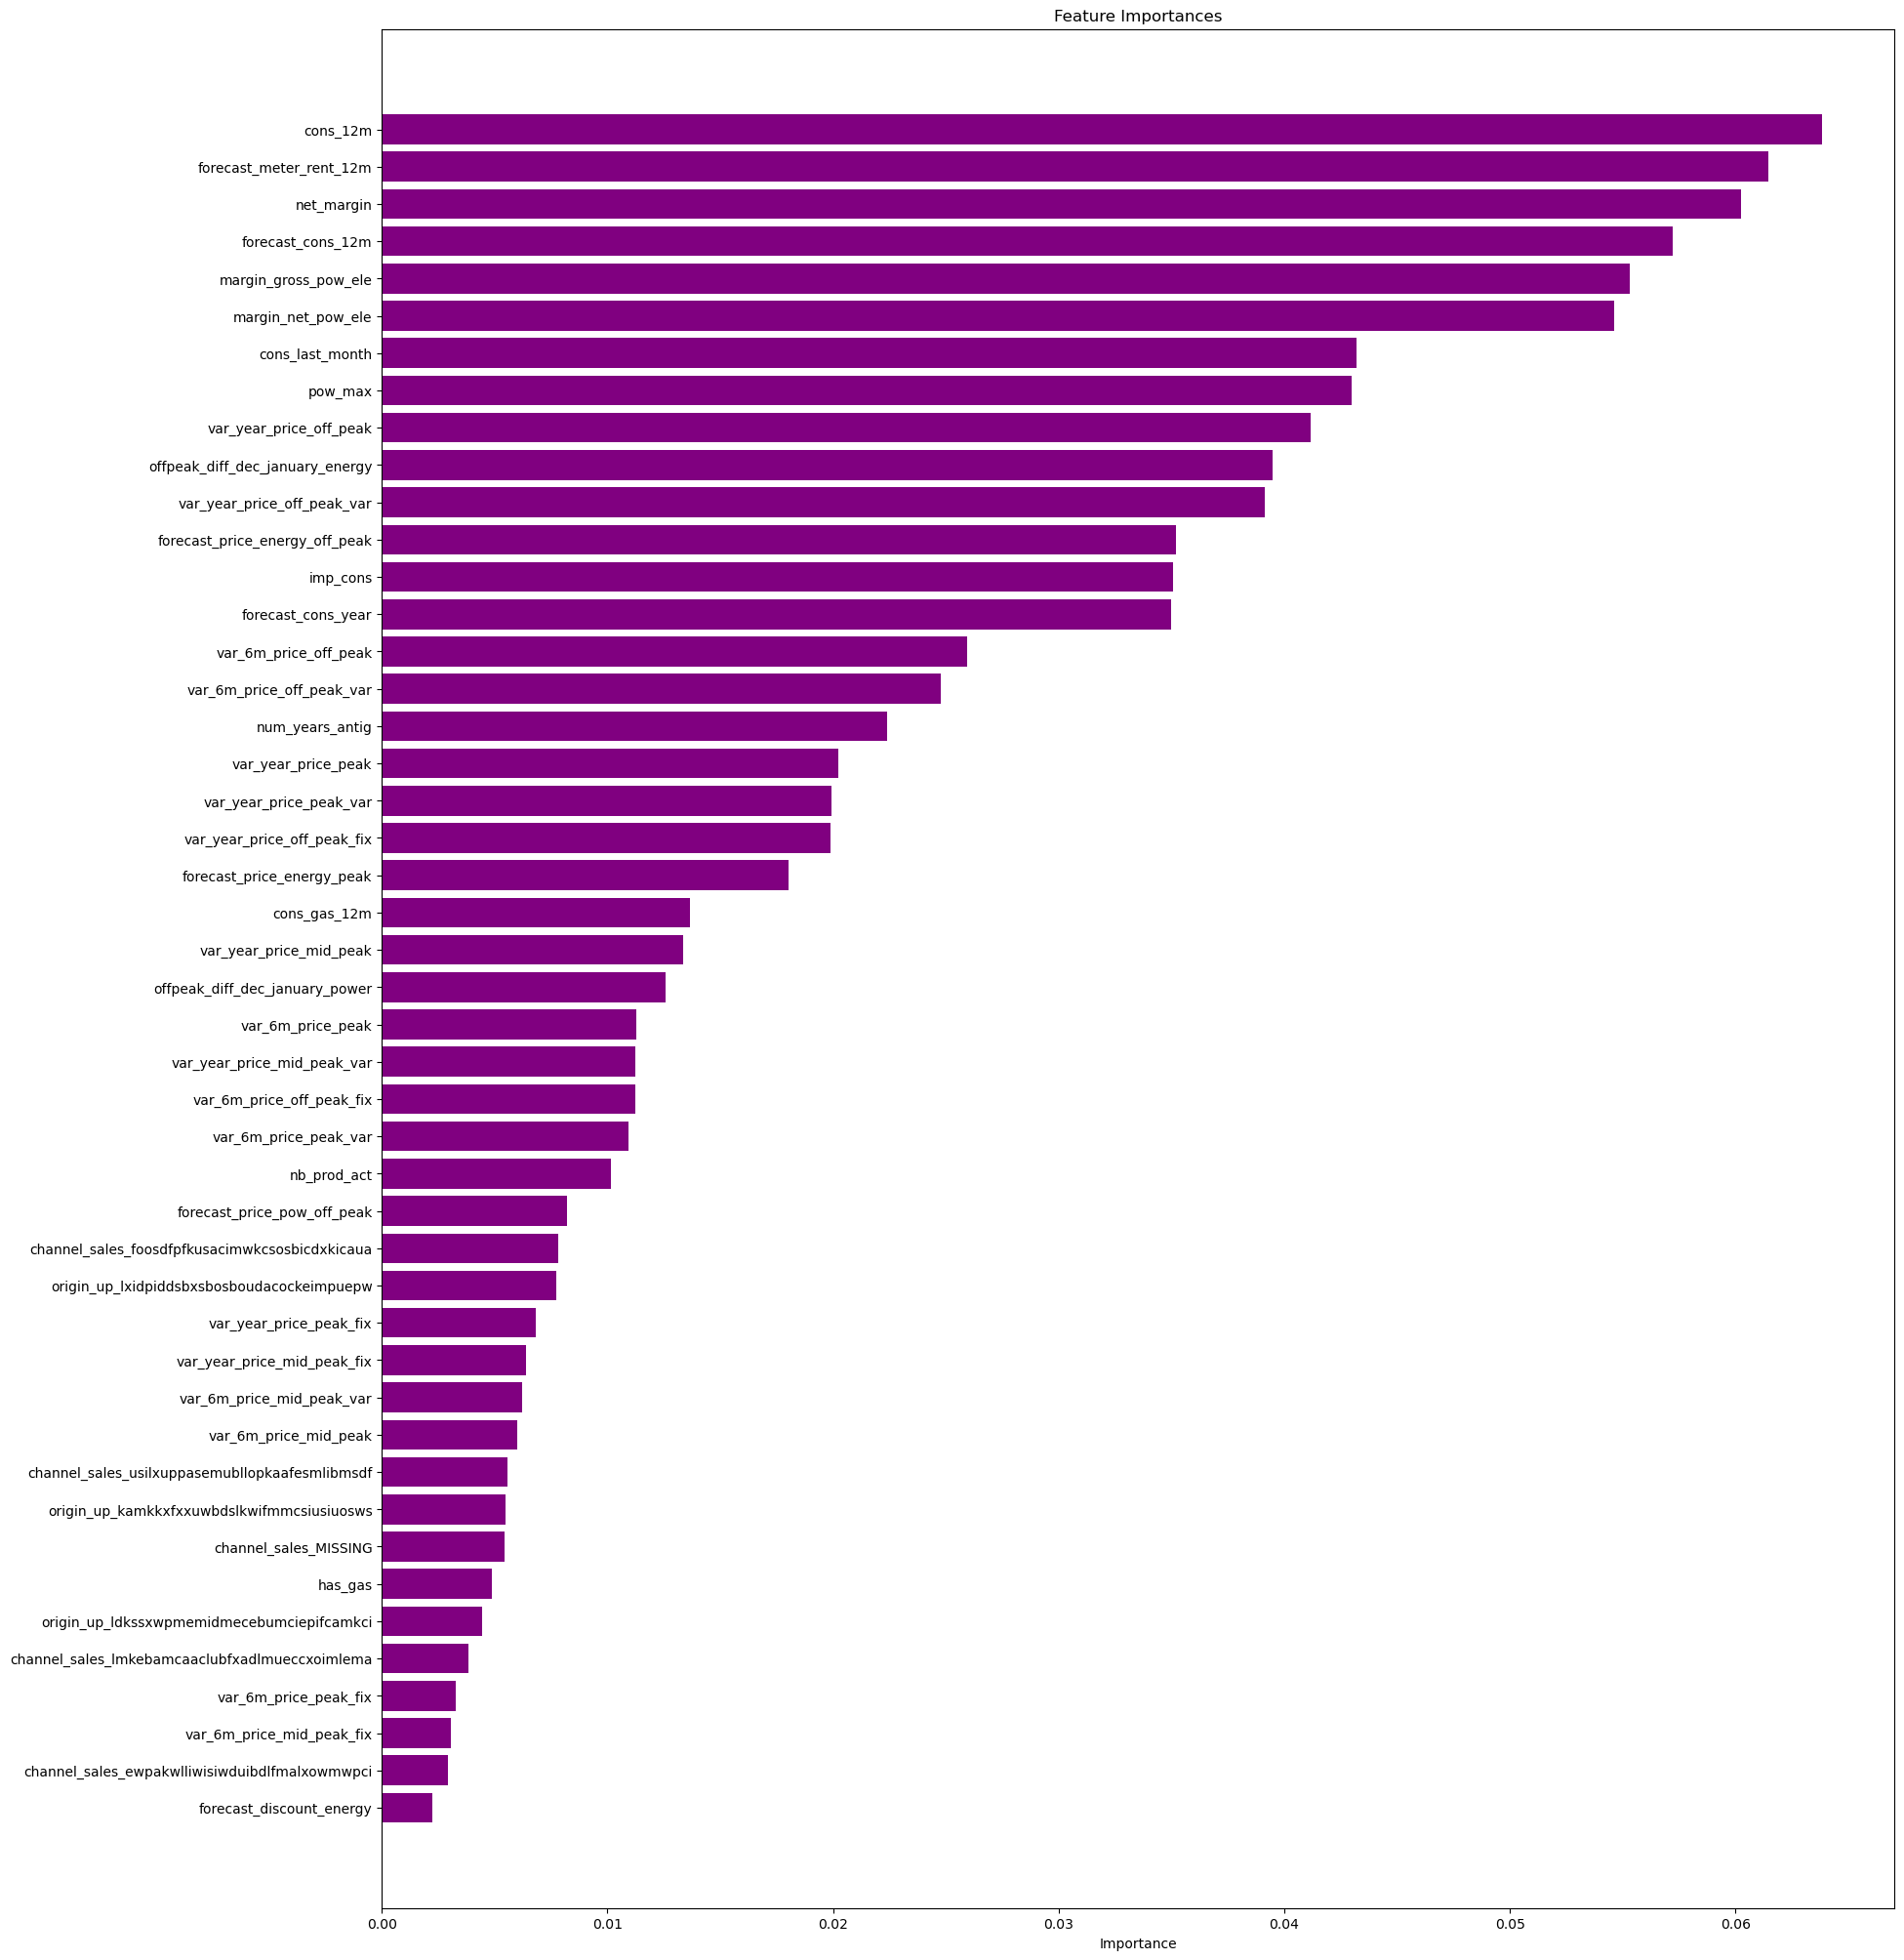

In [98]:
plt.figure(figsize=(20, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='purple', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()